# PlantVillage. Cultivos con patologías

## Procesar DataSet PlantVillage



El conjunto de datos de **PlantVillage** contiene 54.304 imágenes. Las imágenes abarcan **14 especies de cultivos**: manzana, arándano, cereza, maíz, uva, naranja, melocotón, pimiento, patata, frambuesa, soja, calabaza, fresa y tomate. Contiene imágenes de 17 enfermedades fúngicas, 4 enfermedades bacterianas, 2 enfermedades causadas por moho (oomicetos), 2 enfermedades virales y 1 enfermedad causada por un ácaro. 12 especies de cultivos también tienen imágenes de hojas sanas que no están visiblemente afectadas por una enfermedad.

**NOTA**: La base de datos de imágenes original ya no está disponible en el repositorio de PlantVillage www.plantvillage.org, se ha preparado una copia de a partir de otras fuentes de otra github.

Se pueden descargar los archivos con las imagenes en el siguiente enlace de __Google Drive__:

<a href="https://drive.google.com/drive/folders/1bSkEQm7bAOzI09kbz0ltLnJjrerEmknG?usp=drive_link">https://drive.google.com/drive/folders/1bSkEQm7bAOzI09kbz0ltLnJjrerEmknG?usp=drive_link</a>

O bien usando el enlace en __UPM Drive__:

<a href="https://drive.upm.es/s/w3Warc6MVZMQ3Xl">Acceso a PlantVillage en UPM Drive</a>


### Modos de ejecución del cuaderno

El cuaderno tiene una serie de variables booleanas que le permite ejecutarlo de diferentes maneras:

- __googleColaboratory__ : estando a True activará las opciones de __acceso a Drive de Google__ y a la ejecución __CUDA de Google Colaboratory__. Para esto último es necesario en el menú de Entorno de ejecución elegir la opción __GPU__.
- __entrenamiento__ : estando a True ejecuta el entrenamiento y guarda los datos a fichero en la carpeta __data__ ya sea en Drive o local. Si está a False recupera la configuración de fichero existente en __data__.

El __entrenamiento__ de un modelo en una máquina CPU como Windows se puede realizar seleccionando un tamaño de imagen pequeño y una red residual poco profunda, pero lo recomendable es una ejecución en una máquina con capacidad GPU. Google Colaboratory tiene un entorno libre que permite hacerlo manteniendo la sesión activa de forma manual. Con una cuenta de pago sería posible hacer esta ejecución en un segundo plano.


In [ ]:
import glob, os
import numpy as np
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm

**Se definen los parámetros de ejecución**

In [1]:
googleColaboratory = False
entrenamiento = False
validacionAbreviada = False
if googleColaboratory:
    import google as goo

## Carga de Datos

PyTorch tiene dos primitivas para trabajar con bases de datos conocidas para hacer pruebas: __torch.utils.data.DataLoader__ y __torch.utils.data.Dataset__.

__Dataset__ almacena los ejemplos y sus correspondientes etiquetas, y __DataLoader__ genera un iterable sobre el conjunto de datos.

Para generar el Dataset desde un directorio se puede utilizar la clase __ImageFolder__ al que se le pasa una carpeta que contendrá subcarpetas y a su vez las subcarpetas los ficheros con las imagenes. Cada subcarpeta define un tipo de datos, por ejemplo hay una subcarpeta para "Manzana saludable".

La única restricción es que los nombres de las subcarpetas sean idénticos entre la carpeta de entrenamiento y validación y de igual número.

Hemos añadido un fichero "Categorias.txt" donde aparece la traducción al español de los nombres de las subcarpetas en el orden aparición de la carpeta.

__Acceso al arbol de directorios de google Drive__

Si está activado el campo booleano __googleColaboratory__ se activará el proceso de conexión con el directorio Drive de google, que requiere la autorización manual del usuario.

Es posible usar una carpeta de google Drive conocido su enlace, por ejemplo:

[Enlace a una copia de PlantVillage](https://drive.google.com/drive/folders/1bSkEQm7bAOzI09kbz0ltLnJjrerEmknG)

Para poder ver esa carpeta compartida es necesario __añadirla como Acceso Directo__ (en la opción del menú emergente Organizar)

In [ ]:
if googleColaboratory:
    goo.colab.drive.mount('/content/drive/')

Mounted at /content/drive/


__Verificación del árbol de directorio del entorno de ejecución__

El entorno de ejecución de googleColab es linux/unix por lo que debemos usar los siguientes comandos para verificar la carpeta actual y las subcarpetas se pueden usar los siguientes comandos de la '_shell_' del sistema operativo:


*   __pwd__ para comprobar la carpeta actual
*   __ls__ para listar las subcarpetas. Se puede lanzar _**ls**_ sin parámetros y lista las subcarpetas de la carpeta encontrada en _pwd_ o _**ls 'carpeta'**_ para listar las subcarpetas de _**'carpeta'**_



In [ ]:
#!pwd
#!ls
#!ls 'drive/My Drive/Colab Notebooks/data/PlantVillage/train'

In [ ]:
if googleColaboratory:
  train_dir = "/content/drive/My Drive/Colab Notebooks/data/PlantVillage/train"
  if validacionAbreviada:
    valid_dir = "/content/drive/My Drive/Colab Notebooks/data/PlantVillage/val_abrev"
  else:
    valid_dir = "/content/drive/My Drive/Colab Notebooks/data/PlantVillage/val"
else:
  train_dir = "./data/PlantVillage/train"
  if validacionAbreviada:
    valid_dir = "./data/PlantVillage/val_abrev"
  else:
      valid_dir = "./data/PlantVillage/val"


__Se ajusta la semilla random de la librería pyTorch y el valor del nº de elementos en cada lote__

In [ ]:
# Se da un valor a las semillas aleatorias
random_seed = 7
torch.manual_seed(random_seed)
# Se ajusta el valor del lote
batch_size = 32

### Generación del Dataset

El dataset vuelca en un tensor todos los datos del conjunto de entrenamiento o de pruebas. En la primera dimensión del tensor se tendrán el número de imagenes que se están utilizando.

Esto se consigue de una manera sencilla con el método __ImageFolder__ que sólo necesita 2 parámetros: el nombre de la carpeta raíz y la función de transformación a tensor de pyTorch.

El dataset que devuelve ImageFolder es una __tupla bidimensional__. La primera dimensión, accesible con __len__, contiene el nº de imagenes en cada uno de los conjuntos. La segunda dimensión tiene 2 elementos en el primero se encuentra la imagen ya transformada en un tensor cuya dimensión se obtiene con __size__, y en el segundo elemento va el indice que identifica a la __clase__ en que se categoriza la imagen.

El objeto Dataset además incluye la variable __classes__ con los nombres de las subcarpetas que se usan para almacenar los nombres de las Plantas y las enfermedades. En el Dataset de validación (_valid_) se conservan los nombres originales en inglés. En el de entrenamiento (_train_) aparece una versión mixta: <b>Planta__Ix_Nombre enfermedad</b>: el nombre de la planta en inglés, un índice para conservar el mismo orden en train y valid y el nombre de la enfermedad en español.

[Detalle documentación Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

In [ ]:
transforma = transforms.Compose([
        transforms.RandomResizedCrop(64),  # image size int or tuple
        # Add more transforms here
        transforms.ToTensor(),  # convert to tensor at the end
])

In [ ]:
from torchvision.datasets import ImageFolder
train = ImageFolder(train_dir, transform=transforma)
valid = ImageFolder(valid_dir, transform=transforma)

__Se comprueban las dimensiones de las diferentes componentes de los 2 datasets__


*   Nº de elementos de los conjuntos de entrenamiento y validación.
*   Nº de componentes de la primera observación (2), con la imagen y la etiqueta.
* Dimensión del tensor de la imagen
* Datos de la imagen para el primer canal (canal de color rojo).

__Nota__ La clase Dataset es de tipo iterador, por lo que los objetos que genera ImageFolder son __iteradores__ por lo que cada llamada al objeto en una sesión hace cambiar los valores.

In [ ]:
len(train), len(valid), len(train[0]), train[0][0].size(), train[0][1], train[0][0][0][0]

(40600,
 10861,
 2,
 torch.Size([3, 64, 64]),
 0,
 tensor([0.2941, 0.2863, 0.2706, 0.2431, 0.2314, 0.2549, 0.2824, 0.2784, 0.2667,
         0.2510, 0.2510, 0.2510, 0.2431, 0.2431, 0.2667, 0.3098, 0.2941, 0.2902,
         0.3020, 0.3020, 0.3020, 0.2980, 0.3098, 0.3137, 0.3137, 0.3255, 0.3098,
         0.3333, 0.3647, 0.3216, 0.3098, 0.3098, 0.2706, 0.2471, 0.2275, 0.2235,
         0.2275, 0.2510, 0.2471, 0.3020, 0.4039, 0.4667, 0.3922, 0.4039, 0.4157,
         0.4157, 0.4157, 0.4196, 0.4157, 0.4157, 0.4196, 0.4196, 0.4275, 0.4431,
         0.4549, 0.4549, 0.4471, 0.4353, 0.4353, 0.4353, 0.4314, 0.4353, 0.4471,
         0.4353]))

__Se recupera los nombres de las clases a partir de los textos de las subcarpetas__

Para ello se elimina la parte en inglés y el índice

In [ ]:
categoriasIngles = train.classes
Categorias = []
for catIngles in categoriasIngles:
    pos = catIngles.find('__') + 3
    catIngles = catIngles[pos:len(catIngles)]
    pos = catIngles.find('_') + 1
    catIngles = catIngles[pos:len(catIngles)]
    Categorias.append(catIngles)


__Se visualiza el resultado de las categorias con el nombre de la enfermedad con el tipo de planta__

In [ ]:
import pandas as pd
df = pd.DataFrame(Categorias, columns=['Enfermedad'])
df.head()

,Enfermedad
0,Costra del manzano
1,Podredumbre negra del manzano
2,Manzano con roya
3,Manzano sano
4,Arándano sano


__También se visualiza el aspecto que tiene algún tipo de hoja elegido al azar del dataset__

__Nota__: en la llamada a la función se usa la variable anteponiendo un asterísco para desplegar la tupla en sus 2 componentes: la imagen y la etiqueta

In [ ]:
# Función para chequear algunas de las imagenes de los datasets
def show_image(image, label):
    print("Clase : " + Categorias[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Clase : Costra del manzano(0)


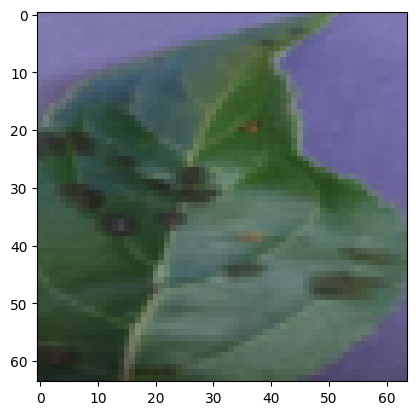

In [ ]:
show_image(*train[0])

Clase : Virus del rizado amarillo del tomate(37)


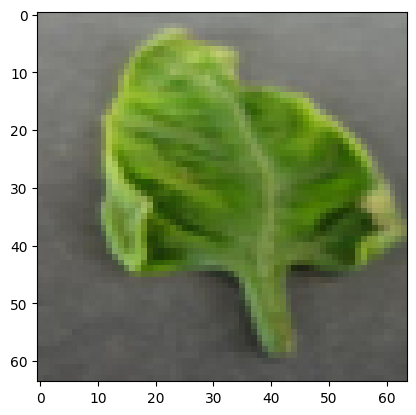

In [ ]:
show_image(*valid[-1])

### Generación del DataLoader

El objeto __DataLoader__ es un iterador de Python que se genera a partir del Dataset. A la __función DataLoader__ se le pasan los parámetros:
- __Nombre del dataset__.
- __Tamaño de lote__.
- Opcionalmente __shuffle__ a True para ordenar aleatoriamente los datos del dataset.
- Opcionalmente __num_workers__, indica el número de suprocesos que se están utilizando (siendo por defecto 0 para usar sólo el proceso principal)
- Opcionalmente __pin_memory__. Si es Verdadero, el DataLoader copiará los tensores en la memoria del dispositivo/CUDA antes de devolverlos.

[Para un mayor detalle consultar aquí](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [ ]:
from torch.utils.data import DataLoader # for dataloaders
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

__Ahora se visualiza un bloque del conjunto de entrenamiento, hay que tener en cuenta que el orden de los datos se ha cambiado aleatoriamente__

In [ ]:
from torchvision.utils import make_grid
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

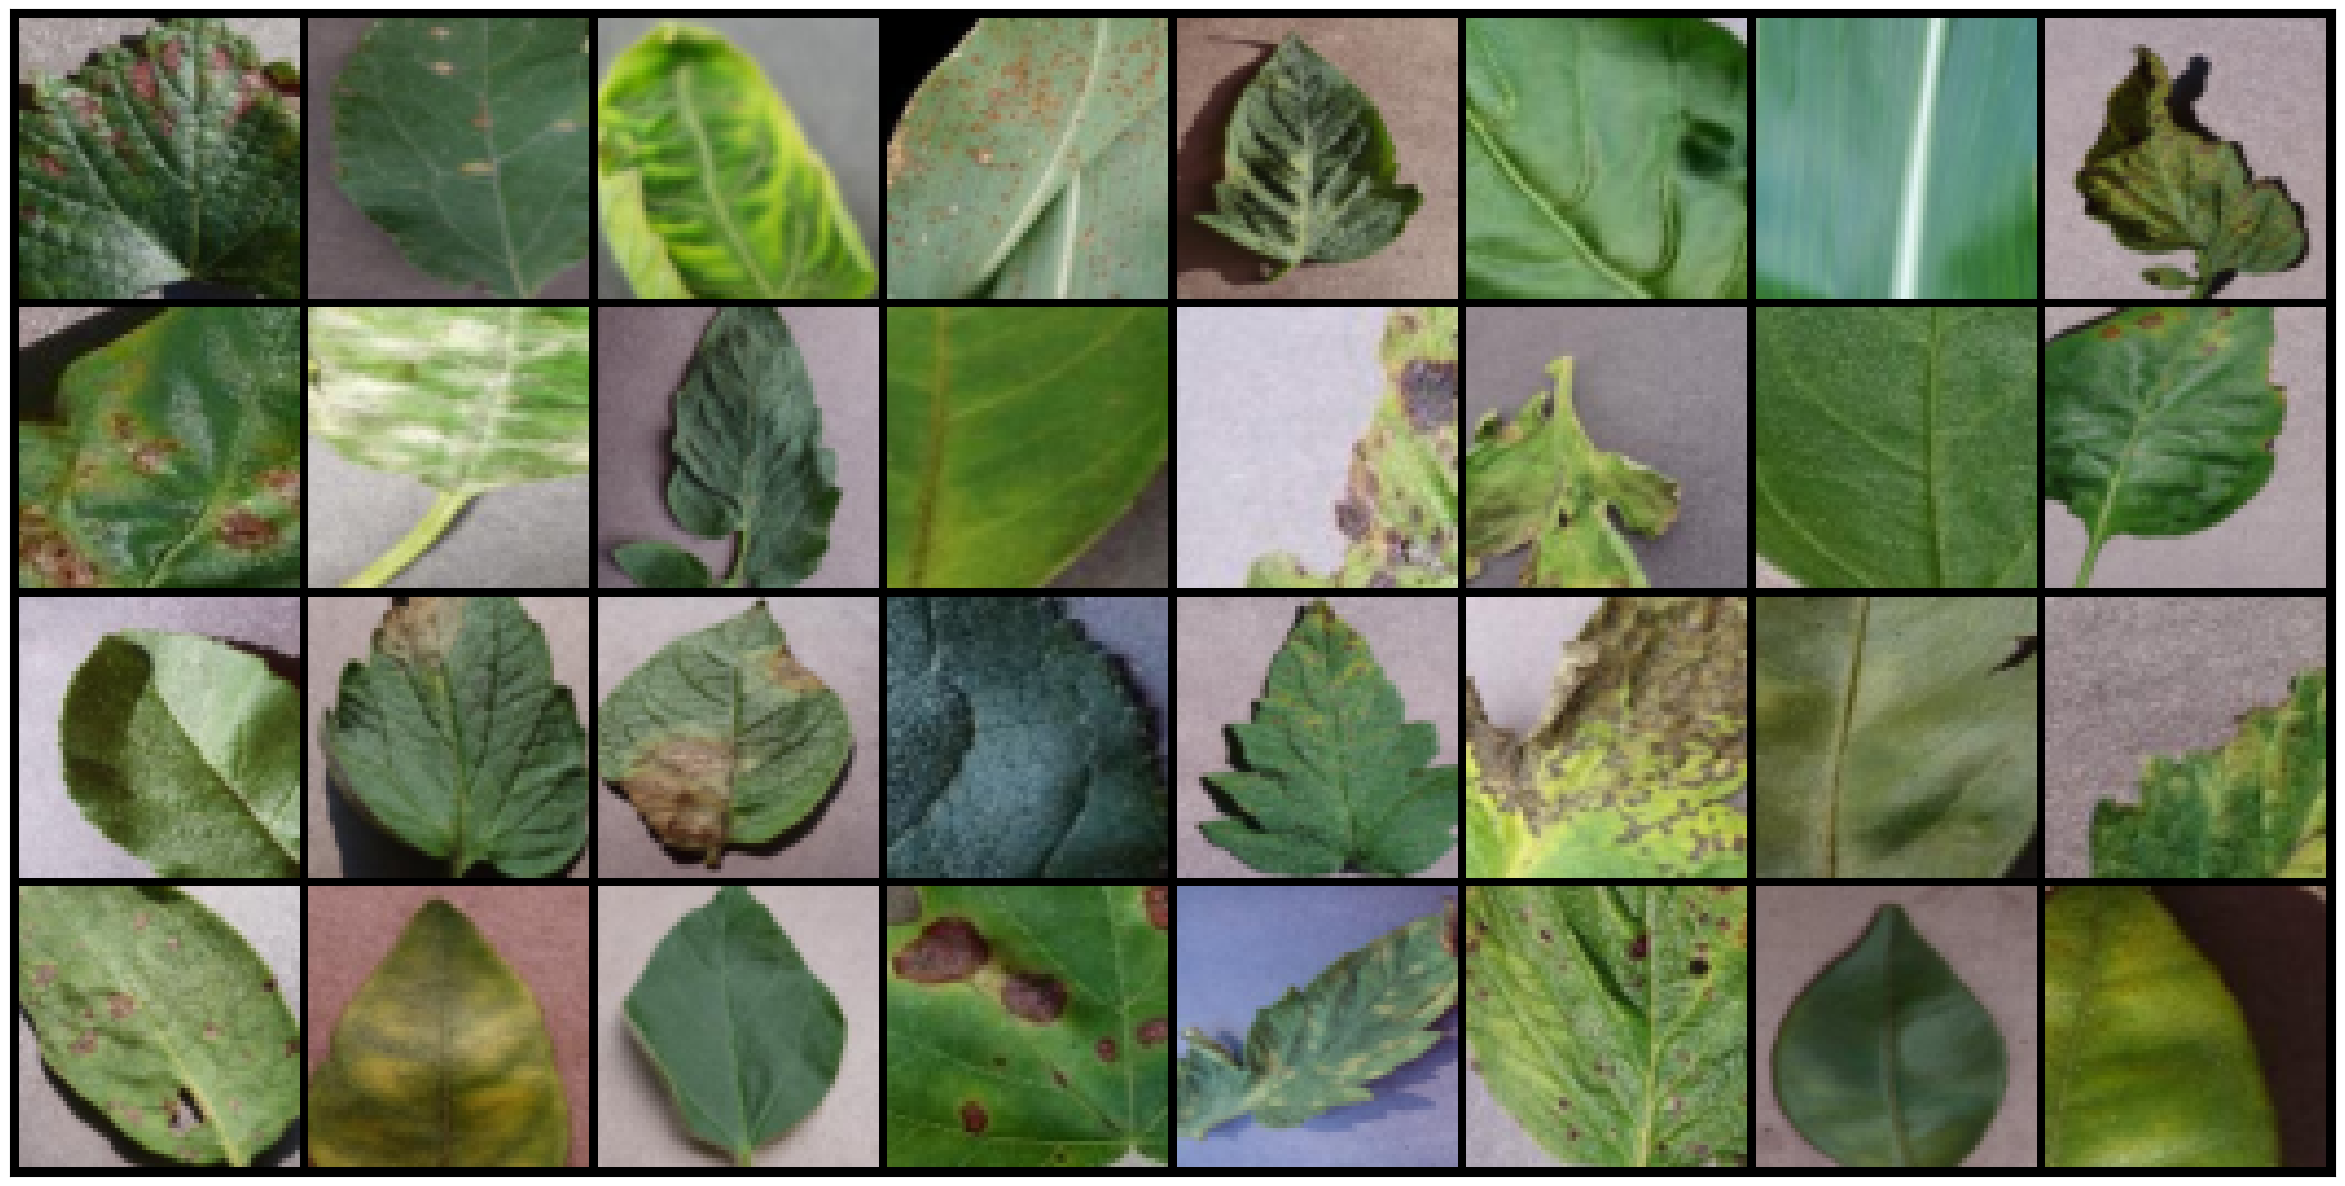

In [ ]:
# Images for first batch of training
show_batch(train_dl)

## Clases con la definición de la Red

El modelo se construye a partir de la definición prefijada en la librería para una red residual, ya sea de profundidad 18 o 50. Y además se hace una carga por defecto de los pesos de la red.

In [ ]:
#from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
# Load the ResNet50 model
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
#model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
# Parallelize training across multiple GPUs
model = torch.nn.DataParallel(model)

# Set the model to run on the device
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

__Se imprime el parámetro del dispositivo__

Para ver si está en __cuda__, __cpu__, etc.

In [ ]:
device

device(type='cuda')

### Especificar la Función de Pérdida y el Optimizador

Hay que especificar la función de pérdida con la que se calculan los errores en la capa final de la red. En este caso utilizamos la __entropía cruzada__ que proporciona la librería.

Y además indicamos la forma como se optimizan los pesos de la red. Esto es, como se van modificando los valores de los pesos para lograr la convergencia. Podemos utilizar el __Gradiente de Descenso Estocástico (SGD)__ o __Adam__.

http://pytorch.org/docs/stable/nn.html#loss-functions

http://pytorch.org/docs/stable/optim.html



In [ ]:
import torch.optim as optim

# Se especifica la función pérdida
loss_func = nn.CrossEntropyLoss()

# Se especifica el optimizador
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

---
## Entrenamiento de la red

En caso de realizar un entrenamiento en línea sin cuenta premium de pago, se recomiendo ejecutar el entrenamiento con entorno __GPU__ con 1 época y una vez entrenado se hace back-up del modelo.

Una vez completado el entrenamiento y el back-up:


*   En la sesión en curso se puede volver a lanzar una nueva época de entrenamiento
*   Si la sesión se cayó habría que recuperar el último back-up antes de lanzar una nueva época de entrenamiento.

El __coste del proceso será mayor__ si: __no se usa GPU__, cuanto __mayor tamaño de imagen__ (desde 32, 64, 128 o 256) o cuanto __más profunda es la red__ (de ResNet18 a ResNet50).



In [ ]:
#from torch.autograd import Variable
num_epochs = 1
model.train()

modulo = 100
lineasTraza = int(len(train_dl)/modulo)+1
numlineas = 0
# Train the model
for epoch in range(num_epochs):
    if not entrenamiento:
      print("No habilitada la opción de entrenamiento")
      break
    print('+'*(modulo-1))
    correct = 0
    total = 0

    for images, labels in train_dl:
        images = images.to(device=device)
        labels = labels.to(device=device)

        output = model(images)
        loss = loss_func(output, labels)
        pred_y = torch.max(output, 1)[1].data.squeeze()
        correct += (pred_y == labels).sum().item()
        total +=float(labels.size(0))
        #print('pred_y=', pred_y, ' labels=', labels, ' correct=', correct, ' total=', total)
        # clear gradients for this training step
        optimizer.zero_grad()

        # backpropagation, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()
        numlineas+=1
        if numlineas == lineasTraza:
            print('*', end='')
            numlineas=0

    print ('\nÉpoca [{}], Accuracy-Entrenamiento {:.4f}'.format(epoch + 1, 100*correct/total))

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
*************************************************************************************************
Época [1], Accuracy-Entrenamiento 90.2512


## Guardar el modelo

In [ ]:
filename = "PlantVillage.pt"
filename = "/content/drive/My Drive/Colab Notebooks/data/" + filename if googleColaboratory else  "data/" + filename
if entrenamiento:
    print("Backup al fichero=", filename)
    torch.save(model.state_dict(), filename)
    if googleColaboratory:
      goo.colab.files.download(filename)
else:
    print("No habilitado Backup del fichero")


Backup al fichero= /content/drive/My Drive/Colab Notebooks/data/PlantVillage.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recuperar el modelo

In [ ]:
if entrenamiento:
    print('No activada la recuperación en modo entrenamiento')
else:
    device = torch.device('cpu')
    if googleColaboratory:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
    print('Entorno de ejecución activo=', device)
    filename = "PlantVillage.pt"
    filename = "/content/drive/My Drive/Colab Notebooks/data/" + filename if googleColaboratory else "data/" + filename
    print("Fichero cargado=", filename)
    model.load_state_dict(torch.load(filename, map_location=torch.device(device))) #recovery trained model
    model.eval()
    print(model)

Entorno de ejecución activo= cuda
Fichero cargado= /content/drive/My Drive/Colab Notebooks/data/PlantVillage.pt
DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), strid

## Validación

In [ ]:
tot_labels = []
tot_predic = []
modulo = 50
lineasTraza = int(len(valid_dl)/modulo)+1
print('+'*(modulo-1))
numlineas = 0

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_dl:
        images = images.to(device=device)
        labels = labels.to(device=device)
        output = model(images)
        pred_y = torch.max(output, 1)[1].data.squeeze()
        for lbl in labels:
          tot_labels.append(lbl.cpu().numpy())
        for y in pred_y:
          tot_predic.append(y.cpu().numpy())
        #print('pred_y=', pred_y, ' labels=', labels, pred_y == labels)
        correct += (pred_y == labels).sum().item()
        total +=float(labels.size(0))
        numlineas+=1
        if numlineas == lineasTraza:
          print('*', end='')
          numlineas=0

    accuracy=100*correct/total

+++++++++++++++++++++++++++++
****************************
El Acierto en los 10861 ejemplos de validación es : 94.07 %


In [ ]:
print('\nEl Acierto en los %d ejemplos de validación es : %.2f %%' % (len(tot_labels), accuracy))

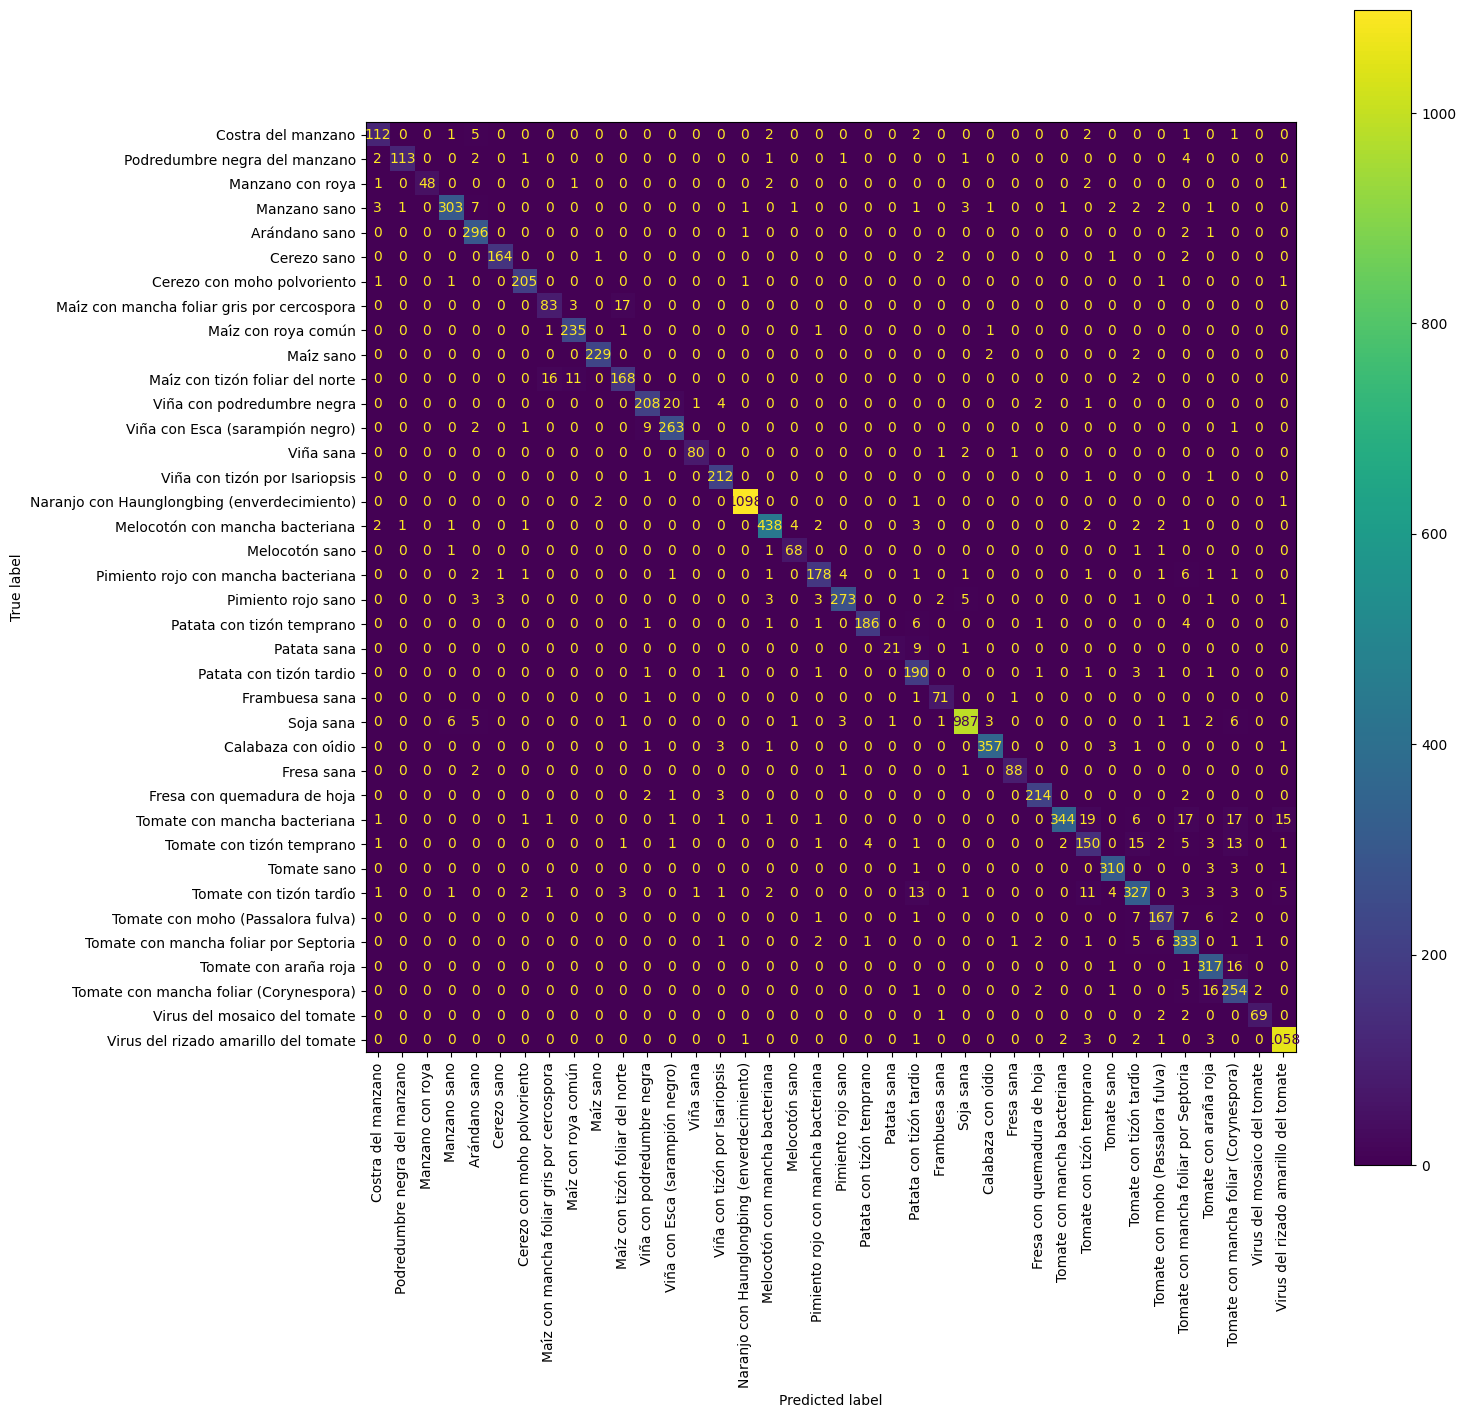

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=tot_labels, y_pred=tot_predic)
cm_display = ConfusionMatrixDisplay(cm, display_labels=Categorias)
fig, ax = plt.subplots(figsize=(15, 15))
cm_display.plot(ax=ax, xticks_rotation=90)
plt.show()